# Exploring the Euro Soccer Dataset
#### Check out the dataset here: https://www.kaggle.com/datasets/hugomathien/soccer

In [1]:
# Importing all the relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings(action = 'ignore')

### Handling SQLite data format
The data is in SQLite file so let's use sqlite3 an inbuilt package in the python standard libary to extract the data from a SQLite databse to pandas dataframe

In [294]:
# # Esatblishing connection with db
conn = sqlite3.connect("database.sqlite")
cur = conn.cursor()

# # Checking the values in 'Player Attribute' table
# cur.execute("""SELECT * FROM Player_Attributes LIMIT 3""")
# for row in cur:
#     print(row)

# # Checking the names of all tables in the db    
# cur.execute("""SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name""")
# for row in cur:
#     print(row)

# # Saving all column names on 'Player Attribut' table 
# table_col_names = []
# cur.execute("""PRAGMA table_info(Player_Attributes)""")
# for row in cur:
#     table_col_names.append(row[1])

# # Closing connection
# cur.close()
# conn.close()

In [295]:
# Checking the values in 'Player Attribute' table
# cur.execute("""SELECT * FROM Match LIMIT 3""")
# for row in cur:
#     print(row)

#### Tables in the SQLite database and their relevant columns:
- Countries: ['id', 'name']
- League: ['id', 'country_id', 'name']
- Match: ['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession']
- Player: ['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday', 'height', 'weight']
- Team: ['id', 'team_api_id', 'team_fifa_api_id', 'team_long_name', 'team_short_name']
- Team Attributes: ['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed', 'buildUpPlaySpeedClass', 'buildUpPlayDribbling', 'buildUpPlayDribblingClass']
- Player Attributes ('df')

Saving SQL tables to pandas dataframe:

#### Countries Table:

In [296]:
df_countries_raw = pd.read_sql_query("SELECT * FROM Country", conn)
df_countries = df_countries_raw.copy()
df_countries.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


#### League Table:

In [297]:
df_league_raw = pd.read_sql_query("SELECT * FROM League", conn)
df_league = df_league_raw.copy()
df_league.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


#### Match Table:

In [298]:
df_match_raw = pd.read_sql_query("SELECT * FROM Match", conn)
df_match = df_match_raw.copy()
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


#### Player Table

In [299]:
df_player_raw = pd.read_sql_query("SELECT * FROM Player", conn)
df_player = df_player_raw.copy()
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


#### Teams Table

In [300]:
df_team_raw = pd.read_sql_query("SELECT * FROM Team", conn)
df_team = df_team_raw.copy()
df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


#### Team Attribute Table

In [301]:
df_teamattr_raw = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)
df_teamattr = df_teamattr_raw.copy()
df_teamattr.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


### Let's do some EDA

#### Name of the Tier 1 leagues in their respective countries and a map plot using GeoPandas library

In [302]:
# Name of the leagues of each countries
league_names = pd.merge(left = df_countries, right = df_league, left_on = 'id', 
                        right_on = 'country_id').rename(columns = {'name_x': 'country', 'name_y': 'league_name'})[['country', 'league_name']]
league_names

,country,league_name
0,Belgium,Belgium Jupiler League
1,England,England Premier League
2,France,France Ligue 1
3,Germany,Germany 1. Bundesliga
4,Italy,Italy Serie A
5,Netherlands,Netherlands Eredivisie
6,Poland,Poland Ekstraklasa
7,Portugal,Portugal Liga ZON Sagres
8,Scotland,Scotland Premier League
9,Spain,Spain LIGA BBVA


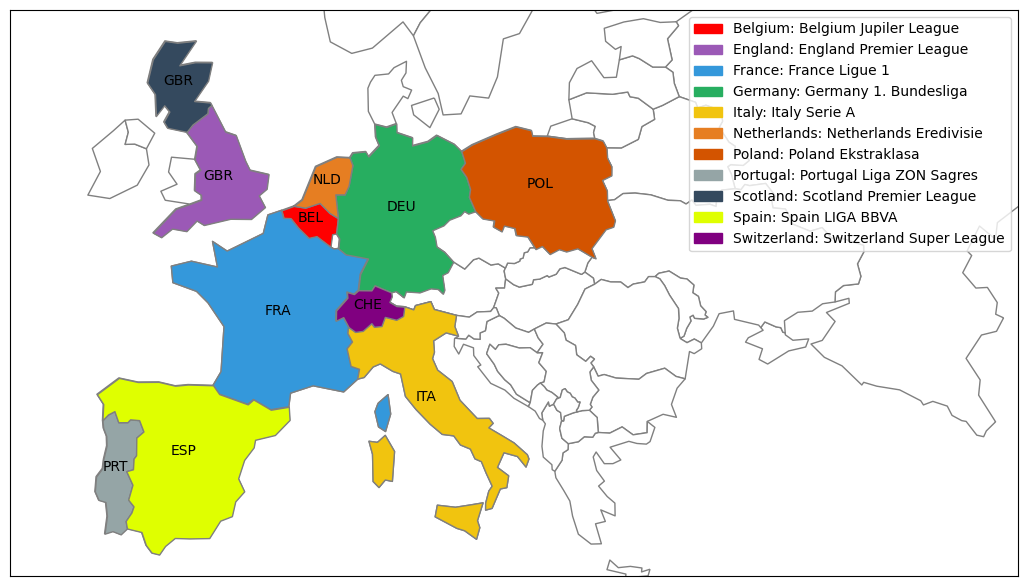

In [303]:
import matplotlib.patches as mpatches
import geopandas as gpd

world = gpd.read_file(r"countries1/ne_110m_admin_0_map_units.shp")

colors = ["#FF0000", "#9B59B6", "#3498DB", "#27AE60", "#F1C40F", "#E67E22", "#D35400", "#95A5A6", "#34495E", "#DFFF00", "#800080"]

ax1 = world[world.CONTINENT == 'Europe'].plot(figsize=(13,9), edgecolor=u'gray', color = "white")

for idx, name in enumerate(league_names.country):
    world[world.NAME == name].plot(edgecolor = u'gray', color = colors[idx], ax=ax1)

for country in league_names.country:
    plt.text(x = world.loc[world.NAME == country].centroid.x.values[0] - 1, 
             y = world.loc[world.NAME == country].centroid.y.values[0], 
             s = world.loc[world.NAME == country]['ADM0_A3'].values[0])

legends = []
for color, name in zip(colors, league_names.values):
    legends.append(mpatches.Patch(color = color, label = name[0] + ": " + name[1]))
    
# plt.ylabel('Latitude')
# plt.xlabel('Longitude')

plt.xlim(-15, 50)
plt.ylim(35, 60)
plt.xticks([])
plt.yticks([])
plt.legend(handles=legends) #, bbox_to_anchor = [1.55,1.01]
plt.show()

In [304]:
# Might want to scrape data 
# Check what team plays for what league and country

#### Checking out what teams play in what country and league
This can be done by joining match_table and team_table on 'api_id'

In [305]:
temp = pd.merge(left = df_match[['country_id', 'league_id', 'home_team_api_id', 'away_team_api_id']],
         right = df_team[['team_api_id', 'team_long_name']],
         left_on = 'home_team_api_id', right_on = 'team_api_id')
team_league = pd.merge(left = temp, right = df_league, left_on = 'country_id', right_on = 'id')
team_league_country = pd.merge(left = team_league, right = df_countries, left_on = 'country_id_x', right_on = 'id')[['team_long_name', 'name_x', 'name_y']]
team_league_country = team_league_country.rename(columns = {'team_long_name': 'team','name_x': 'league', 'name_y': 'country'})
# team_league_country.head()

In [306]:
from great_tables import GT

leagues = team_league_country.groupby('league')['team'].unique()
league_names = pd.DataFrame()
for ln in leagues.index:
    temp = pd.Series(data = leagues[ln])
    league_names = pd.concat([league_names, temp], axis = 1)
league_names.columns = leagues.index
league_names = league_names.fillna("")
team_names = (
    GT(league_names)
    .tab_header(
        title = "League & Teams That Have Played There",
        subtitle = "From Year 2008 - 2016"
    )
)

team_names

Belgium Jupiler League,England Premier League,France Ligue 1,Germany 1. Bundesliga,Italy Serie A,Netherlands Eredivisie,Poland Ekstraklasa,Portugal Liga ZON Sagres,Scotland Premier League,Spain LIGA BBVA,Switzerland Super League
KRC Genk,Manchester United,AJ Auxerre,FC Bayern Munich,Atalanta,Vitesse,Wisła Kraków,FC Porto,Falkirk,Valencia CF,Grasshopper Club Zürich
SV Zulte-Waregem,Arsenal,Girondins de Bordeaux,Bayer 04 Leverkusen,Cagliari,Roda JC Kerkrade,Polonia Bytom,Sporting CP,Heart of Midlothian,CA Osasuna,BSC Young Boys
KSV Cercle Brugge,Sunderland,Le Havre AC,FC Schalke 04,Catania,Willem II,Legia Warszawa,Vitória Guimarães,Kilmarnock,RC Deportivo de La Coruña,FC Aarau
KAA Gent,West Ham United,Le Mans FC,VfL Wolfsburg,Chievo Verona,N.E.C.,Śląsk Wrocław,FC Paços de Ferreira,Aberdeen,CD Numancia,FC Luzern
FCV Dender EH,Aston Villa,Olympique Lyonnais,Eintracht Frankfurt,Fiorentina,FC Utrecht,Widzew Łódź,Amadora,Celtic,Racing Santander,Neuchâtel Xamax
KV Mechelen,Everton,AS Monaco,DSC Arminia Bielefeld,Milan,Heracles Almelo,Lech Poznań,Rio Ave FC,Hamilton Academical FC,Real Sporting de Gijón,AC Bellinzona
KSV Roeselare,Middlesbrough,AS Nancy-Lorraine,FC Energie Cottbus,Roma,Sparta Rotterdam,Arka Gdynia,Leixões SC,Dundee United,Real Betis Balompié,FC Basel
Tubize,Bolton Wanderers,Stade Rennais FC,Borussia Mönchengladbach,Sampdoria,FC Volendam,Piast Gliwice,Naval 1° de Maio,Inverness Caledonian Thistle,RCD Espanyol,FC Sion
KVC Westerlo,Hull City,FC Sochaux-Montbéliard,Karlsruher SC,Torino,AZ,GKS Bełchatów,SL Benfica,Rangers,Athletic Club de Bilbao,FC Vaduz
Club Brugge KV,Chelsea,Valenciennes FC,Hamburger SV,Udinese,De Graafschap,Jagiellonia Białystok,CF Os Belenenses,Motherwell,Atlético Madrid,FC Zürich


#### Let's check out the number of unique teams that have played in each league over the 8 year period between 2008 - 2016
- Every year some teams which finish at the bottom of the table are relegated to a lower league and the winner of lower leagues get promoted to play in the top league (the number of teams relegated varies from 2 to 3 depending on the league) hence the variable number of teams that have competed throughout the years
- Some leagues like the Swiss and Scottish leagues have a maximum of 12 teams playing in the league
- Whereas some leagues have had 16 - 18 teams playing in the league throughout the 8 year stretch
- Other bigger leagues have had 20 teams competing throughout the 8 year stretch 
#### The French league has had the highest number of unqiue teams that have played throughout the years

In [307]:
unique_teams = team_league_country.groupby('league').nunique()['team']
unique_teams = unique_teams.sort_values()

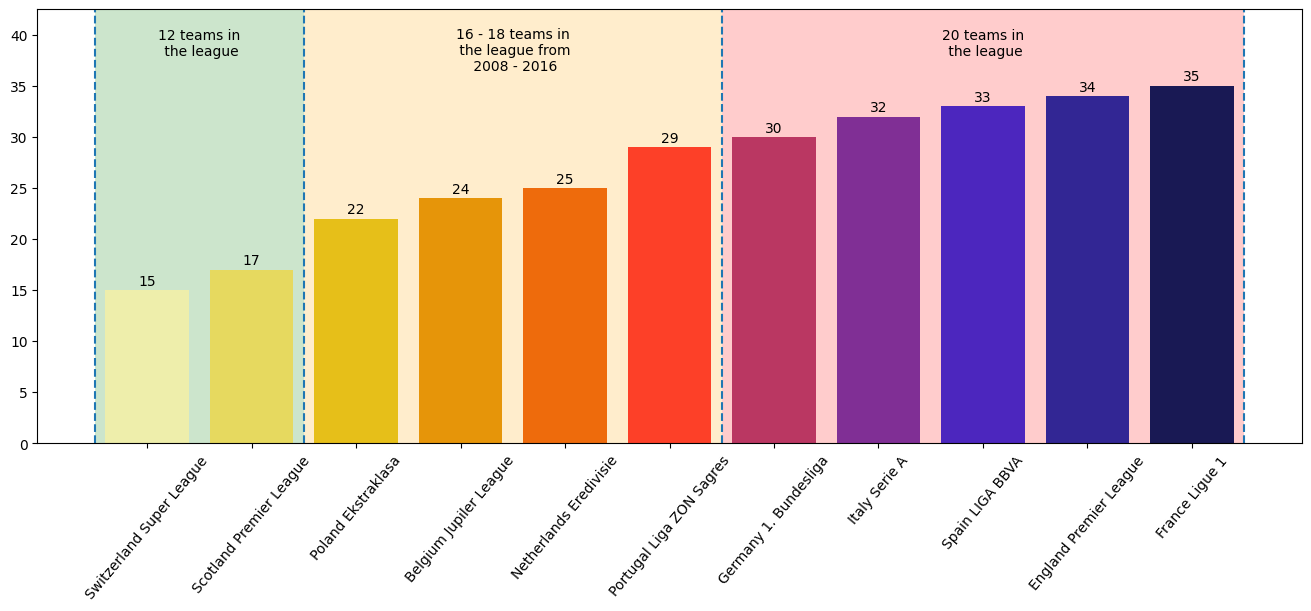

In [308]:
# Leagues with the highest number of unique teams over the 8 year range
plt.figure(figsize = (13, 6), layout = 'constrained')

pal = list(sns.color_palette(palette='CMRmap_r', n_colors=len(unique_teams.values)).as_hex())

plt.axvspan(-0.5, 1.5, color='g', alpha=0.2, lw=0)
plt.axvspan(1.5, 5.5, color='orange', alpha=0.2, lw=0)
plt.axvspan(5.5, 10.5, color='r', alpha=0.2, lw=0)

plt.bar(x = unique_teams.index, height = unique_teams.values, color = pal)

plt.tick_params(axis = 'x', rotation = 50)
for i, j in enumerate(unique_teams.values):
    plt.text(x = i, y = j + 0.5, s = j, ha = 'center')

plt.vlines(x = -0.5, ymin = 0, ymax = 45, linestyles = 'dashed')
plt.vlines(x = 1.5, ymin = 0, ymax = 45, linestyles = 'dashed')
plt.vlines(x = 5.5, ymin = 0, ymax = 45, linestyles = 'dashed')
plt.vlines(x = 10.5, ymin = 0, ymax = 45, linestyles = 'dashed')

plt.text(x = 0.5, y = 38, s = '12 teams in\n the league', ha = 'center')
plt.text(x = 3.5, y = 36.5, s = '16 - 18 teams in\n the league from\n 2008 - 2016', ha = 'center')
plt.text(x = 8, y = 38, s = '20 teams in\n the league', ha = 'center')

plt.ylim(0, 42.5)
plt.show()

#### Which league scored the highest average amount of goals per season
Again this can be obtained by joining match_table and team_table (I have replaced leagues which has had 16-18 teams with an average of 17 to simplify calculation)
- Grouping by all the leagues and summing the total goals scored and then normalizing the values with number of teams in the league to make them comparable
- Turns out the Dutch Eredivisie has the highest amount of goals throughout the 8 year period

In [309]:
temp = pd.merge(left = df_match, right = df_team, left_on = 'home_team_api_id', right_on = 'team_api_id')
team_league = pd.merge(left = temp, right = df_league, left_on = 'country_id', right_on = 'id')
team_league_country = pd.merge(left = team_league, right = df_countries, left_on = 'country_id_x', right_on = 'id')
# team_league_country = team_league_country.rename(columns = {'team_long_name': 'team','name_x': 'league', 'name_y': 'country'})
team_league_country_goal = team_league_country[['season', 'home_team_goal', 'away_team_goal', 'team_long_name', 'name_x', 'name_y']]
team_league_country_goal['total_goals'] = team_league_country_goal['home_team_goal'] + team_league_country_goal['away_team_goal']
total_goals = team_league_country_goal.groupby('name_x').sum()['total_goals']
total_goals = total_goals.to_frame()
total_goals['team_number'] = [17, 20, 20, 20, 20, 17, 17, 17, 12, 20, 12]
total_goals['total_avg'] = total_goals['total_goals'] / total_goals['team_number']
total_goals = total_goals.sort_values('total_avg').reset_index().rename(
    columns = {'name_x': 'League' , 'team_number': 'Total Teams' , 'total_avg': 'Total Average'})[['League', 'Total Teams', 'Total Average']]

In [310]:
cm = sns.light_palette("green", as_cmap=True)
total_goals.style.background_gradient(cmap=cm).set_precision(2)

,League,Total Teams,Total Average
0,Poland Ekstraklasa,17,273.88
1,Belgium Jupiler League,17,284.76
2,Portugal Liga ZON Sagres,17,305.94
3,Switzerland Super League,12,347.17
4,Germany 1. Bundesliga,20,355.15
5,France Ligue 1,20,371.35
6,Italy Serie A,20,394.75
7,Scotland Premier League,12,400.33
8,England Premier League,20,412.00
9,Spain LIGA BBVA,20,420.60


Importing player_attribute_table

In [2]:
conn = sqlite3.connect('database.sqlite')
df_raw = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
conn.close()

In [3]:
df = df_raw.copy()

In [313]:
# df.head()

#### The player attribute table has a column called 'overall_rating' which is a score between 0-100 and it is dependent on various metric relevant to a football game like attack, defence etc...
Let us check if right footed players have a higher ratings than left footed players (just curious)
- Both the distributions looks to have a very similar mean, variance and the distribution is roughly normally distributed
- Let's further invstigate if there is a statistical significant difference between let and right footed players
- Since the number of samples of each players is high enough and but we do not know the population standard deviation we can conduct a 2 sample t test (the observations are independent of each others too)
- The null hypothesis here being 0 difference in their means

In [4]:
print("Right footed players:", df.loc[df.preferred_foot == 'right'].shape)
print("Left footed players:", df.loc[df.preferred_foot == 'left'].shape)

Right footed players: (138409, 42)
Left footed players: (44733, 42)


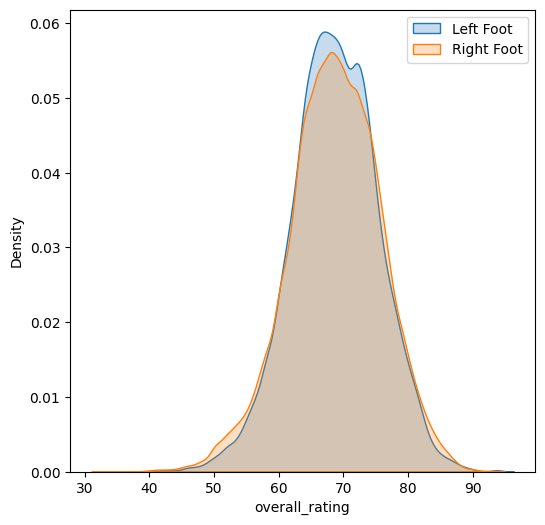

In [5]:
right_foot = df.loc[df.preferred_foot == 'right']['overall_rating']
left_foot = df.loc[df.preferred_foot == 'left']['overall_rating']
plt.figure(figsize = (6, 6))
sns.kdeplot(data = left_foot, fill = True, label = 'Left Foot')
sns.kdeplot(data = right_foot, fill = True, label = 'Right Foot')
plt.legend()

In [6]:
np.mean(right_foot) - np.mean(left_foot)

-0.03462366085950919

#### Difference in rating of left and right footed players overall ratings doesn't seem to be statistically signficant (p-value not below 0.05) 

In [7]:
import scipy.stats as stats
print(stats.ttest_ind(a=right_foot, b=left_foot, equal_var=True))

Ttest_indResult(statistic=-0.9041323794079107, pvalue=0.36592640017311073)


## Let us check if we can model 'overall_rating' using the other player attributes as feature (Linear Regression)

In [318]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [319]:
df.shape

(183978, 42)

#### Data cleaning
- Let's drop some irrelevant features and some rows with null values (roughly 2% of data dropped, data seems to be missing at random with no structure to it)
- Let's convert all the categorical columns to model suitable numerical columns

In [320]:
df.drop(["id", "player_fifa_api_id", "player_api_id", "date"], axis = 1, inplace = True)

In [321]:
# df.loc[df.isna().sum(axis = 1) > 0][500:550]

In [322]:
df.dropna(inplace = True)
print(df.shape)

(180354, 38)


Let's investigate if the categorical columns are ordinal data

In [323]:
cat_cols = df.select_dtypes(include = 'object')
cat_cols.nunique()

preferred_foot          2
attacking_work_rate     8
defensive_work_rate    18
dtype: int64

In [324]:
for i in cat_cols.columns:
    print(cat_cols[i].unique())

['right' 'left']
['medium' 'high' 'low' 'None' 'le' 'norm' 'stoc' 'y']
['medium' 'high' 'low' '5' 'ean' 'o' '1' 'ormal' '7' '2' '8' '4' 'tocky'
 '0' '3' '6' '9' 'es']


In [325]:
cat_cols['attacking_work_rate'].value_counts(normalize = True)

medium    0.693470
high      0.237439
low       0.047512
None      0.018392
norm      0.001758
y         0.000521
stoc      0.000477
le        0.000432
Name: attacking_work_rate, dtype: float64

Looks like the 'attacking_work_rate' and 'defensive_work_rate' have ordinal data with some 'None' and typos which are very few in number, I am just going to replace them with a random sample of ordinal values

In [326]:
# Number of samples with "other" values
other_len1 = len(cat_cols.loc[~cat_cols['attacking_work_rate'].isin(['medium', 'high', 'low']), 'attacking_work_rate'])
other_len2 = len(cat_cols.loc[~cat_cols['defensive_work_rate'].isin(['medium', 'high', 'low']), 'defensive_work_rate'])
# Random sampling from existing values
sampled1 = cat_cols.loc[cat_cols['attacking_work_rate'].isin(['medium', 'high', 'low']), 'attacking_work_rate'].sample(n = other_len1, random_state = 10)
sampled2 = cat_cols.loc[cat_cols['defensive_work_rate'].isin(['medium', 'high', 'low']), 'defensive_work_rate'].sample(n = other_len2, random_state = 10)
# Replacing "other" values with sampled data
cat_cols.loc[~cat_cols['attacking_work_rate'].isin(['medium', 'high', 'low']), 'attacking_work_rate'] = sampled1.to_list()
cat_cols.loc[~cat_cols['defensive_work_rate'].isin(['medium', 'high', 'low']), 'defensive_work_rate'] = sampled2.to_list()

'preferred_foot' column has to be One Hot Encoded

In [327]:
cat_cols = pd.get_dummies(cat_cols, columns = ['preferred_foot'], drop_first = True)

Since the columns have ordinal data renaming these values with numbers with 'high' getting a score of 3 and 'low' getting 1

In [328]:
ordinal_encode = {'low': 1, 'medium': 2, 'high': 3}
cat_cols['attacking_work_rate'] = cat_cols['attacking_work_rate'].map(ordinal_encode)
cat_cols['defensive_work_rate'] = cat_cols['defensive_work_rate'].map(ordinal_encode)

In [329]:
df.drop(["preferred_foot", "attacking_work_rate", "defensive_work_rate"], axis = 1, inplace = True)

In [330]:
df = pd.concat([df, cat_cols], axis = 1)
print(df.shape)

(180354, 38)


In [331]:
# df.info()

#### Sampling 50000 observations for further modelling

In [332]:
df_50 = df.sample(n = 50000, random_state = 3)
print(df_50.shape)

(50000, 38)


In [333]:
# df_50.info()

In [334]:
y = df_50['overall_rating']
X = df_50.drop('overall_rating', axis = 1)

In [335]:
col_name = X.columns
y_unscaled = y.copy()

<Axes: xlabel='overall_rating', ylabel='Density'>

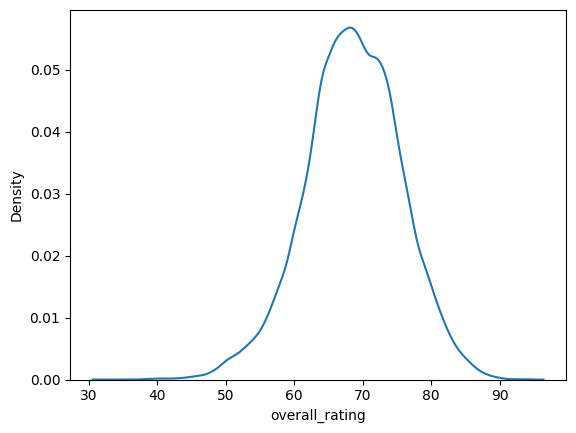

In [336]:
sns.kdeplot(y)

Scaling (z-score scaling) the values before modelling

In [337]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
y_scale = scaler.fit_transform(y.values.reshape((50000, 1)))

In [338]:
X_scale_ = pd.DataFrame(X_scale, columns = col_name)

#### Baseline linear model

In [339]:
# Baseline Model
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_scale, y_scale, test_size = 0.3)
lin_model1 = LinearRegression()
lin_model1.fit(X_train_base, y_train_base)
y_pred1 = lin_model1.predict(X_test_base)
rmse_base = math.sqrt(mean_squared_error(y_true = y_test_base, y_pred = y_pred1))
print("R2 Score:", r2_score(y_true = y_test_base, y_pred = y_pred1))
print("Root Mean Squared Error:", rmse_base)

R2 Score: 0.8409500844431781
Root Mean Squared Error: 0.3971944048980522


#### Checking out the important features using backward elimination technique (p-values)

In [340]:
import statsmodels.regression.linear_model as sm

In [341]:
def backward_elimination(X, y):
    significant_cols = np.array(range(37))
    p_val = [1]
    while len(p_val) > 0:
        stat_ols = sm.OLS(endog = y, exog = X[:, significant_cols]).fit()
        p_val = np.argwhere(stat_ols.pvalues>0.05).flatten()
        significant_cols = np.argwhere(stat_ols.pvalues != np.max(stat_ols.pvalues)).flatten()
    return significant_cols
features = backward_elimination(X_scale, y_scale)
print("Number of features after backward elimination:", len(features))

Number of features after backward elimination: 15


Checking the correlation between features

In [342]:
features = col_name[features]
X_ols = X_scale_.loc[:, features]

In [343]:
X_train_ols, X_test_ols, y_train_ols, y_test_ols = train_test_split(X_ols, y_scale, test_size = 0.3)
lin_model2 = LinearRegression()
lin_model2.fit(X_train_ols, y_train_ols)
y_pred2 = lin_model2.predict(X_test_ols)
rmse_ols = math.sqrt(mean_squared_error(y_true = y_test_ols, y_pred = y_pred2))
print(rmse_ols)

0.4866376504492742


In [344]:
X_train_ols.shape

(35000, 15)

<Axes: >

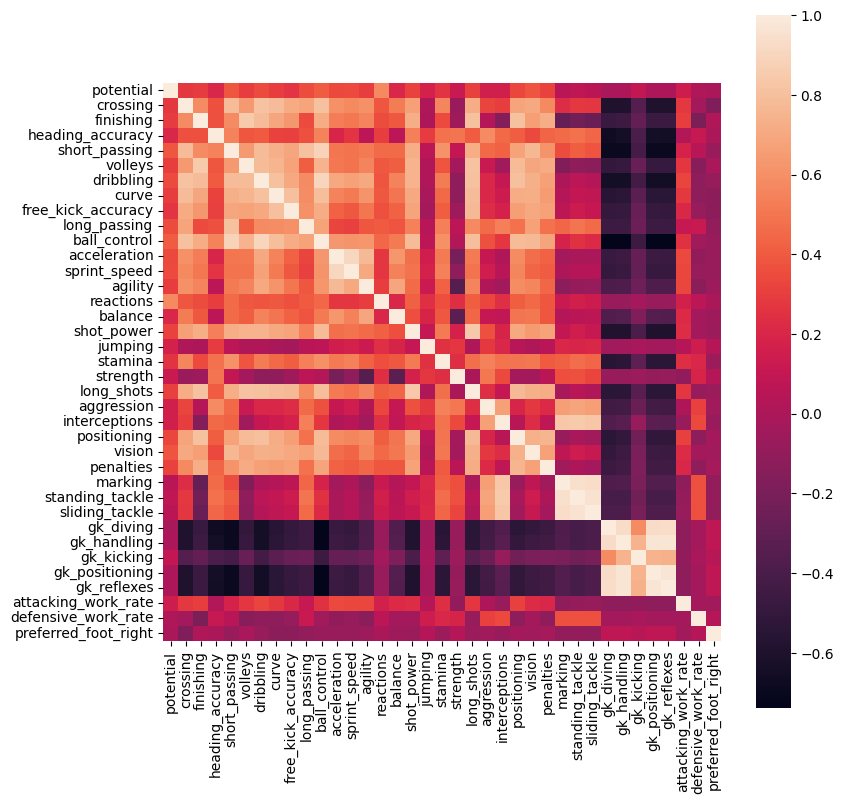

In [345]:
plt.figure(figsize = (9,9))
sns.heatmap(X.corr(), square = True)

We have dropped 26 features using this method


Some features seem to be highly correlated with each other and according to Prof. Cosma Shalizi in his book "Truth About Linear Regression" he mentions in the topic "Why Variable Selection Using p-Values Is a Bad Idea" (pg no. 372) that using p-values for feature selection might not be the most robust metric and suggests readers to opt with othe metric like AIC


#### There is an easy implementaion of Backward feature selection using AIC metic in R

#### Features obtained from backward elimination process done in R, using AIC metric
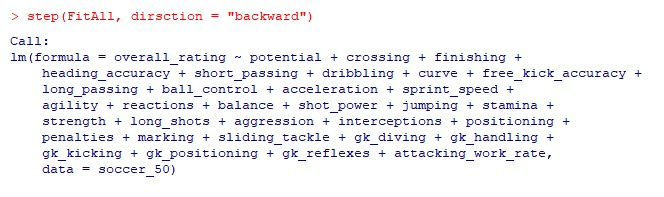

In [346]:
r_features = '''potential + crossing + finishing + heading_accuracy + short_passing + dribbling + curve + free_kick_accuracy + 
    long_passing + ball_control + acceleration + sprint_speed + 
    agility + reactions + balance + shot_power + jumping + stamina + 
    strength + long_shots + aggression + interceptions + positioning + 
    penalties + marking + sliding_tackle + gk_diving + gk_handling + 
    gk_kicking + gk_positioning + gk_reflexes + attacking_work_rate
    '''

In [347]:
r_features = [i for i in r_features.split() if i != "+"]
len(r_features)

32

Using the backward selection from R we were able to select 32 features that is 5 less than the original data, now let's see how good our model performs

In [348]:
X_r = X_scale_.loc[:, r_features]

Model performs that same with fewer features

In [349]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_scale, test_size = 0.3)
lin_model3 = LinearRegression()
lin_model3.fit(X_train_r, y_train_r)
y_pred3 = lin_model3.predict(X_test_r)
rmse_r = math.sqrt(mean_squared_error(y_true = y_test_r, y_pred = y_pred3))
print(rmse_r)

0.3990514666087978


#### Let's check the residuals in the training and testing dataset:

In [350]:
# RMSE of training data
y_pred4 = lin_model3.predict(X_train_r)
rmse_r_train = math.sqrt(mean_squared_error(y_true = y_train_r, y_pred = y_pred4))
print(rmse_r_train)

0.3969333907656542


In [351]:
# Checking residuals
e1_train = y_pred4 - y_train_r
e1_test = y_pred3 - y_test_r

Both training and testing looks to have a similar variance of error which is desirable

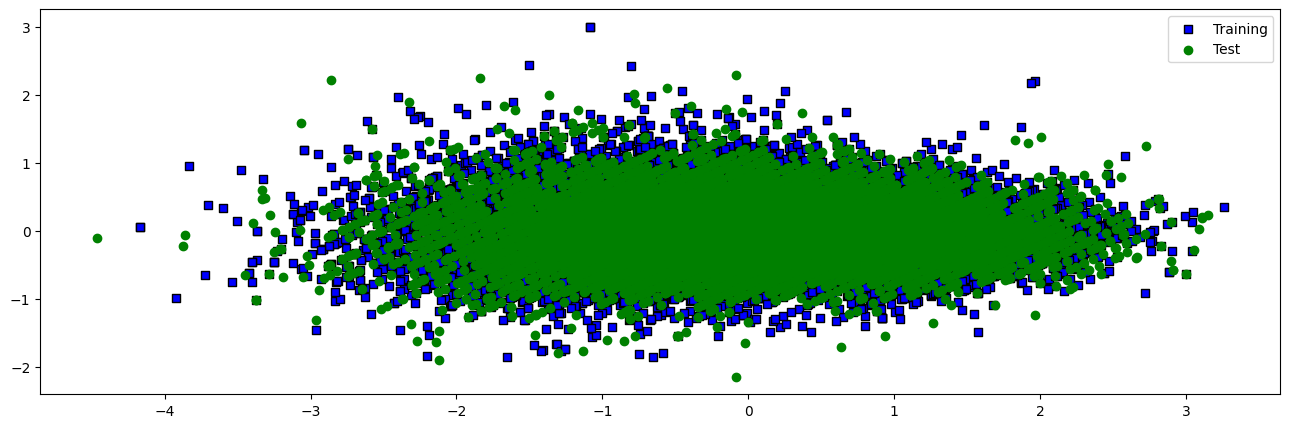

In [352]:
plt.figure(figsize = (16, 5))
plt.scatter(x = y_pred4, y = e1_train, c = 'blue', marker = 's', label = 'Training', edgecolors = 'black')
plt.scatter(x = y_pred3, y = e1_test, c = 'green', label = 'Test')
plt.legend()

#### Applying Ridge and Lasso Regression to see if they gives better models

In [353]:
# L2 regularization
from sklearn.linear_model import RidgeCV, LassoCV

X_train, X_test, y_train, y_test = train_test_split(X_scale_, y_scale, test_size = 0.3)

lin_ridge = RidgeCV(alphas = [2200, 2300, 2400, 2500, 2600], cv = 10)
lin_ridge.fit(X_train, y_train)
print("Best alpha", lin_ridge.alpha_)

y_pred5_train = lin_ridge.predict(X_train)
y_pred5_test = lin_ridge.predict(X_test)

rmse_ridge_train = math.sqrt(mean_squared_error(y_true = y_train, y_pred = y_pred5_train))
print(rmse_ridge_train)
rmse_ridge_test = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred5_test))
print(rmse_ridge_test)

Best alpha 2200
0.40279498152199
0.40039674654905183


In [354]:
# L1  regularization
lin_lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1], max_iter = 50000, cv = 10)
lin_lasso.fit(X_train, y_train)
print("Best alpha", lin_lasso.alpha_)

y_pred6_train = lin_lasso.predict(X_train)
y_pred6_test = lin_lasso.predict(X_test)

rmse_lasso_train = math.sqrt(mean_squared_error(y_true = y_train, y_pred = y_pred6_train))
print(rmse_lasso_train)
rmse_lasso_test = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred6_test))
print(rmse_lasso_test)

Best alpha 0.0001
0.39835218611492723
0.3954982710035669


Checking to see if some coefficents have been reduced to zero in Lasso


Most of the coefs have not dropped to zero since alpha is very low

<BarContainer object of 37 artists>

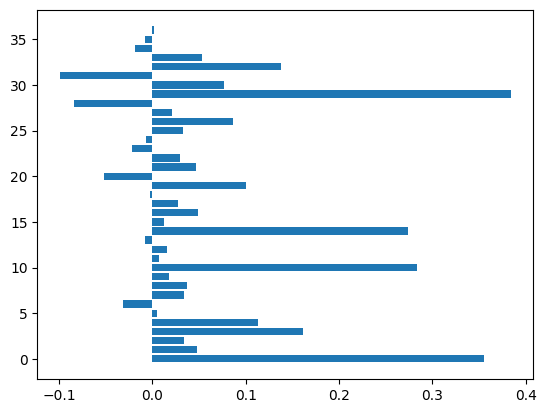

In [355]:
plt.barh(y = pd.Series(lin_lasso.coef_).index, width = lin_lasso.coef_, align = 'center')

#### Checking polymnomial regression

In [356]:
# Trying polynomial fetures
pipe = Pipeline(steps = [('poly', PolynomialFeatures(degree = 2)),
                         ('lassoCV', Lasso(alpha = 0.1))])

In [357]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()), ('lassoCV', Lasso(alpha=0.1))])

In [358]:
y_pred7_poly = pipe.predict(X_test)
rmse_poly = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred7_poly))
print(rmse_poly)

0.4682311471317686


### Finally choosing the best model

In [359]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.linear_model import Lasso
def rmse_scorer(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

In [360]:
be = cross_validate(LinearRegression(), X_r, y_scale, cv = 5, scoring = make_scorer(rmse_scorer))['test_score']
print("Backward Elimination:", be.mean())
l1 = cross_validate(Lasso(alpha = 0.001), X_scale, y_scale, cv = 5, scoring = make_scorer(rmse_scorer))['test_score']
print("Linear Regression with L1 pealty:", l1.mean())

Backward Elimination: 0.3978530195503295
Linear Regression with L1 pealty: 0.39803427549678855


### Conclusion:
### Simple linear regression with selective features obtained from Backward Elimination performs as well as Regression model with L1 penalty

In [361]:
# from sklearn.ensemble import RandomForestRegressor
# rf1 = RandomForestRegressor()
# rf1.fit(X_train_base, y_train_base.flatten())
# y_pred2 = rf1.predict(X_test_base)
# print("Mean of predicted values:", y_pred2.mean())
# rmse_rf = math.sqrt(mean_squared_error(y_true = y_test_base, y_pred = y_pred2))
# print("RMSE:", rmse_rf)